# Anomaly Screening Applying Pseudo-wells (ASAP)

Stavanger Machine Learning Hackathon 18-19 September, 2018.

Project page: <https://events.agilescientific.com/project/asap>

## Pseudowell creation

This notebook shows how to:

* read well data;
* simplify elastic logs by "blocking" (i.e., replacing the natural, high-frequency variations of the recorded logs, with a constant value averaged over certain intervals of interest);
* create pseudo-logs by modifying blocked logs within reservoir section to simulate different conditions of fluid content, porosity and thickness following a given rock physics model;
* creating near and far-offset synthetic seismograms using as inputs the above pseudo-logs;
* output synthetic seismograms to be fed into notebook #2 (seismic data analysis via ML).

## To-do

* details on the rock physics model.

### Running the notebook

The following cell shows the required libraries to be loaded. Apart from the usual ones (`numpy`, `matplotlib`, `pandas`), we also have [`bruges`](https://agilescientific.com/bruges/) by Agile Scientific and another helper library that we put together to make these notebooks leaner called `asap_library`, included in the [ASAP github repo](https://github.com/aadm/ASAP).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bruges as b
import asap_library as al
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload
%autoreload 2

### Data loading and QC

We first read in well data from Per Avseth's [open dataset distributed with the first edition of QSI (Quantitative Seismic Interpretation)](https://srb.stanford.edu/quantitative-seismic-interpretation).

Well 2 corresponds to the Glitne well 15/5-5 drilled in 1995. Well 5 is 15/5-6 (1997) and well 3 is 15/5-3. For all the informations related to these wells check [NPD's Factpages](http://factpages.npd.no/factpages/).

In [2]:
w2=pd.read_csv('qsiwell2.csv', index_col=0)
w3=pd.read_csv('qsiwell3.csv', index_col=0)
w5=pd.read_csv('qsiwell5.csv', index_col=0)

wells = [ w2,       w3,       w5]
names = ['15/5-5','15/5-3', '15/5-6']

The logs available in well 2 (Glitne 15/5-5) are:

In [3]:
for i in range(w2.columns.size):
    print('Log {} = {}'.format(i,w2.columns[i]))

Log 0 = VP
Log 1 = VS
Log 2 = RHO_OLD
Log 3 = GR
Log 4 = NPHI
Log 5 = RHO
Log 6 = SWE
Log 7 = SWX
Log 8 = VPVS
Log 9 = IP
Log 10 = IS
Log 11 = VSH
Log 12 = RHOm
Log 13 = RHOf
Log 14 = PHIE


Build a simple Pandas dataframe with the most relevant stratigraphic markers (Lista Fm. is the caprock shale and Heimdal Fm. is the reservoir sand):

In [5]:
tops_w2={'Lista': 2127, 'Heimdal': 2154}
tops_w3={'Lista': 2153, 'Heimdal': 2180}
tops_w5={'Lista': 2145, 'Heimdal': 2172}
tops=pd.DataFrame()
for i,val in enumerate([tops_w2,tops_w3,tops_w5]):
    tempdf=pd.DataFrame.from_dict(val, orient='index')
    tempdf.columns=[names[i]]
    tops=pd.concat([tops, tempdf],axis=1)

The following code shows the Vp logs from the three wells in a similar way to figure 5.1 that appears at page 259 of the paperback edition of QSI.

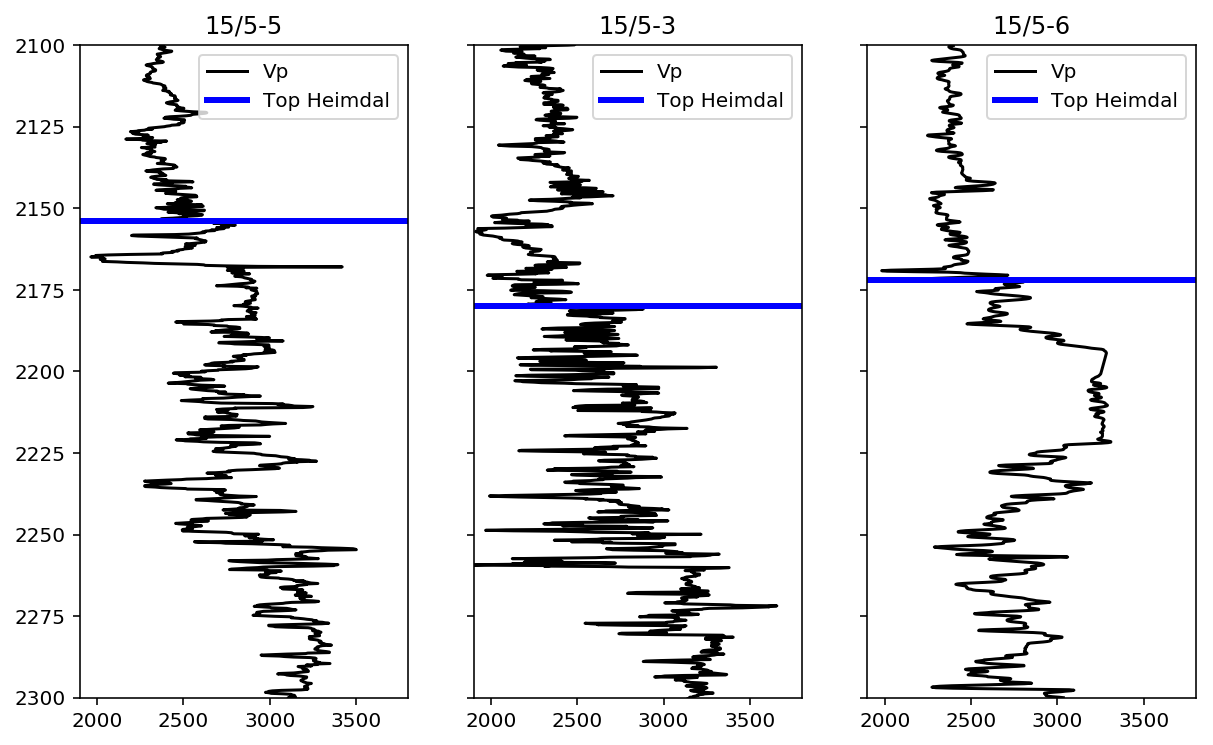

In [47]:
f,ax=plt.subplots(nrows=1,ncols=3, figsize=(10,6), sharey=True)
for i,p in enumerate(wells):
    top = tops[names[i]]['Heimdal']
    ax[i].plot(p.VP, p.index, 'k', label='Vp')
    ax[i].axhline(top, label='Top Heimdal', color='b', lw=3)
    ax[i].set_xlim(1900,3800)
    ax[i].set_ylim(2300,2100)
    ax[i].set_title(names[i])
    ax[i].legend()

In the `asap_library` we have included a function to make a more complete display of the key logs called `quicklook`:

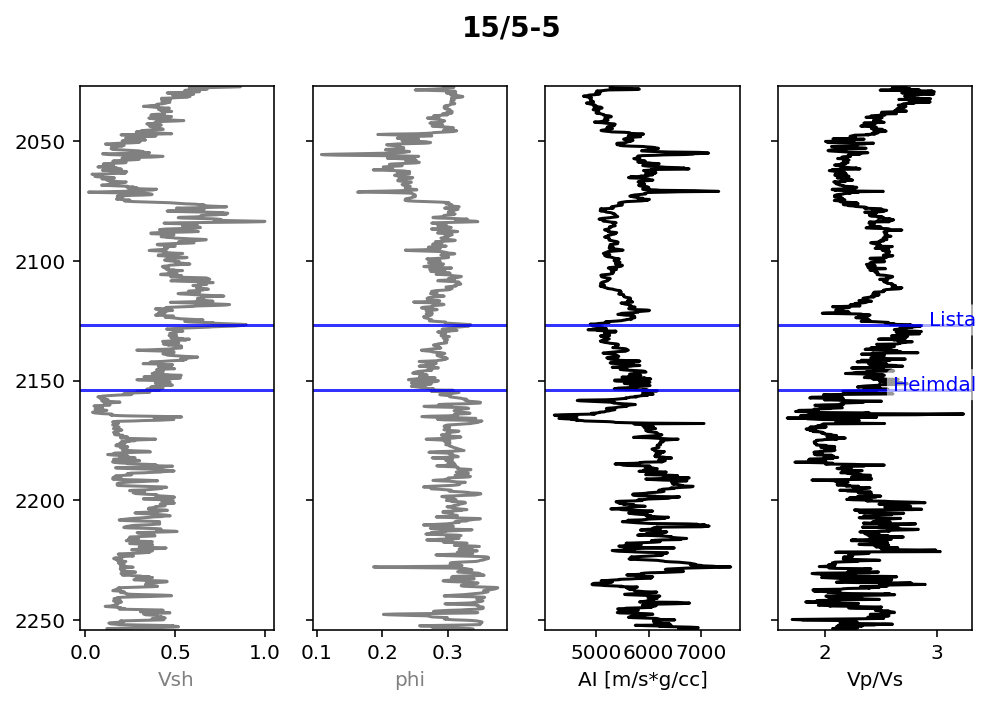

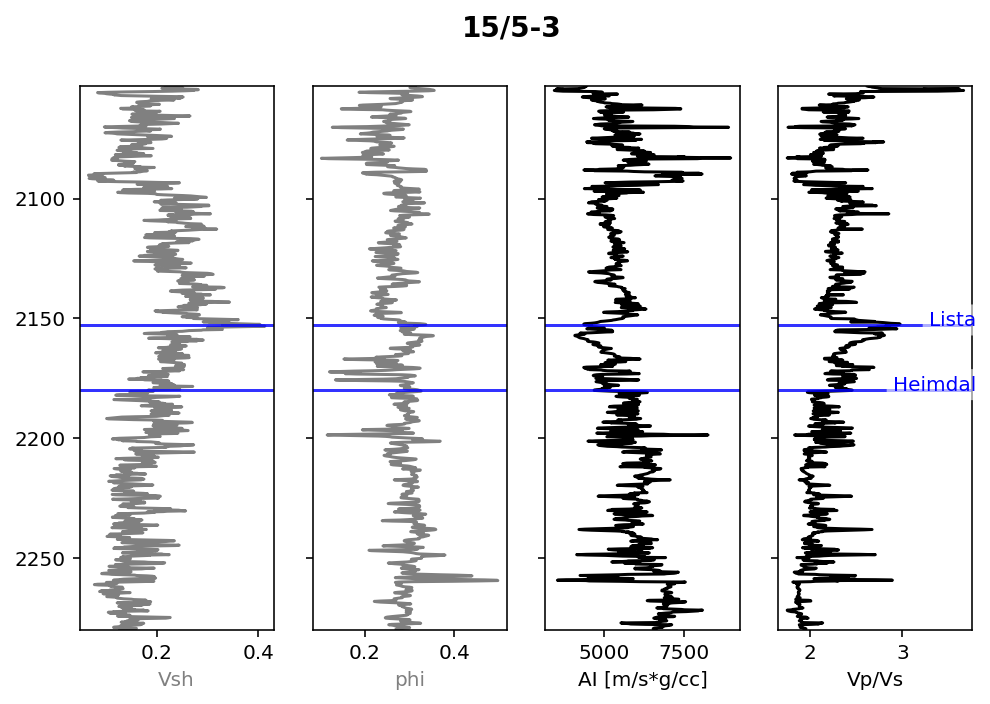

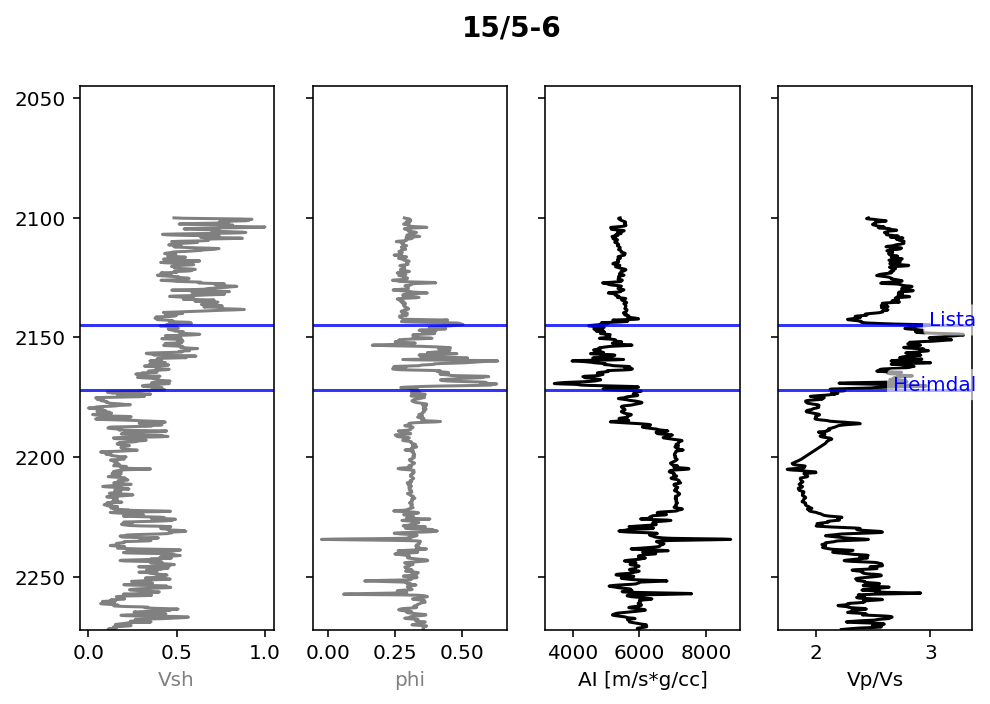

In [6]:
for i,p in enumerate(wells):
    z1 = tops[names[i]]['Lista']-100
    z2 = tops[names[i]]['Heimdal']+100
    al.quicklook(p,ztop=z1,zbot=z2,name=names[i],tops=tops[names[i]])
#     plt.savefig('FIGS/{}_original_wells.png'.format(names[i].replace('/','_')))

We load again well 15/5-5, this is the "final" version with "correct" porosity and fluid-replaced logs used during the hackathon; we will use this dataset for the actual modeling.

In [4]:
well=pd.read_csv('15_5-5.dat', index_col=0)

In the following cell we compare the Vp logs from this dataset (fluid-replaced to brine) and the original insitu version previously loaded:

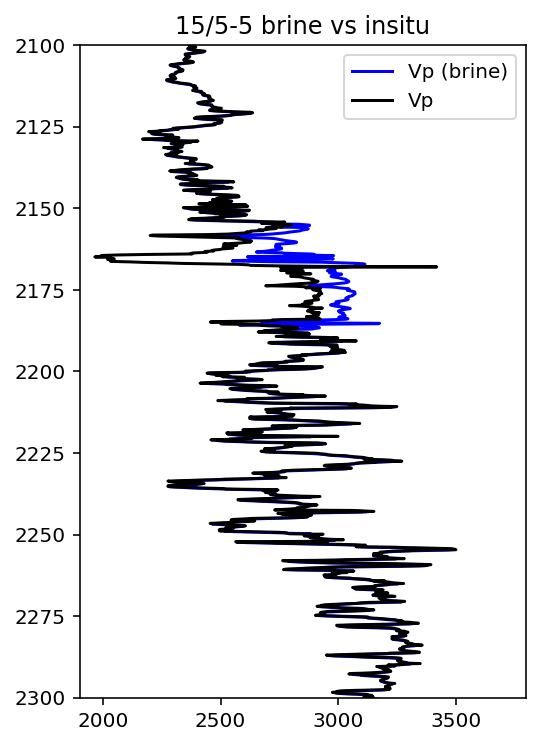

In [51]:
f,ax=plt.subplots(figsize=(4,6))
ax.plot(well.VP_FRMB, well.index, 'b', label='Vp (brine)')
ax.plot(w2.VP, w2.index, 'k', label='Vp')
ax.set_xlim(1900,3800)
ax.set_ylim(2300,2100)
ax.set_title('15/5-5 brine vs insitu')
ax.legend()

In the file `Heimdal_All_Data_for_RP_xplot.txt` we have all the data from the reservoir sections in the three wells already cleaned up and fluid-replaced. We will load it and use it as the calibration data for our rock physics model.

The file is made up of 9 columns of data: shale volume(`VSH`), porosity (`POR`), brine-replaced Vp, Vs and density (`VPB`, `VSB`, `RHOB`), oil-replaced Vp, Vs and density (`VPO`, `VSO`, `RHOO`), depth (`Z`). These vectors are loaded to a Pandas Dataframe that we call `resdata`.

In [91]:
temp_names = ['VSH','POR','VPB','VSB','RHOB','VPO','VSO','RHOO','Z']
resdata = pd.read_csv('Heimdal_All_Data_for_RP_xplot.txt', delim_whitespace=True, skiprows=1, header=None, names=temp_names)

### Rock physics modeling

We use `resdata` as a backdrop to calibrate our rock physics model.

In [105]:
%cd ../SQUIT
import squit
%cd ../ASAP

C:\Users\ag19324\GoogleDrive\PYTHON\_GITHUB\SQUIT
C:\Users\ag19324\GoogleDrive\PYTHON\_GITHUB\ASAP


In [130]:
critpor=0.38
coordn=20-34*critpor+14*critpor**2
Kcem, Gcem, Dcem = 36.8, 44, 2.65
Koil, Kbri = 1.1, 2.75
Doil, Dbri = 0.8, 1.09
Kclay, Gclay = 17.5, 7.5
Kqtz, Gqtz  = 36.8, 44

volcement=0.02
por_hs=critpor-volcement
por_ccm=np.linspace(0,critpor,100)
porvec=np.linspace(0,por_hs,100)

In [131]:
vsh=0.1
sw=1.0
_,_,_,_,K0,G0  = squit.rp.vrh([vsh, 1-vsh],[Kclay,Kqtz],[Gclay,Gqtz])
D0=2.65

_,Kf,_,_,_,_ = squit.rp.vrh([sw, 1-sw],[Kbri,Koil],[0,0])
Df=sw*Dbri+(1-sw)*Doil

In [132]:
Kdry, Gdry = squit.rp.contactcement(K0, G0, por_ccm, phi_c=critpor, Cn=coordn, Kc=Kcem, Gc=Gcem, scheme=2)
vp,vs,rho,_= squit.rp.vels(Kdry,Gdry,K0,D0,Kf,Df,por_ccm)

(1900, 5500)

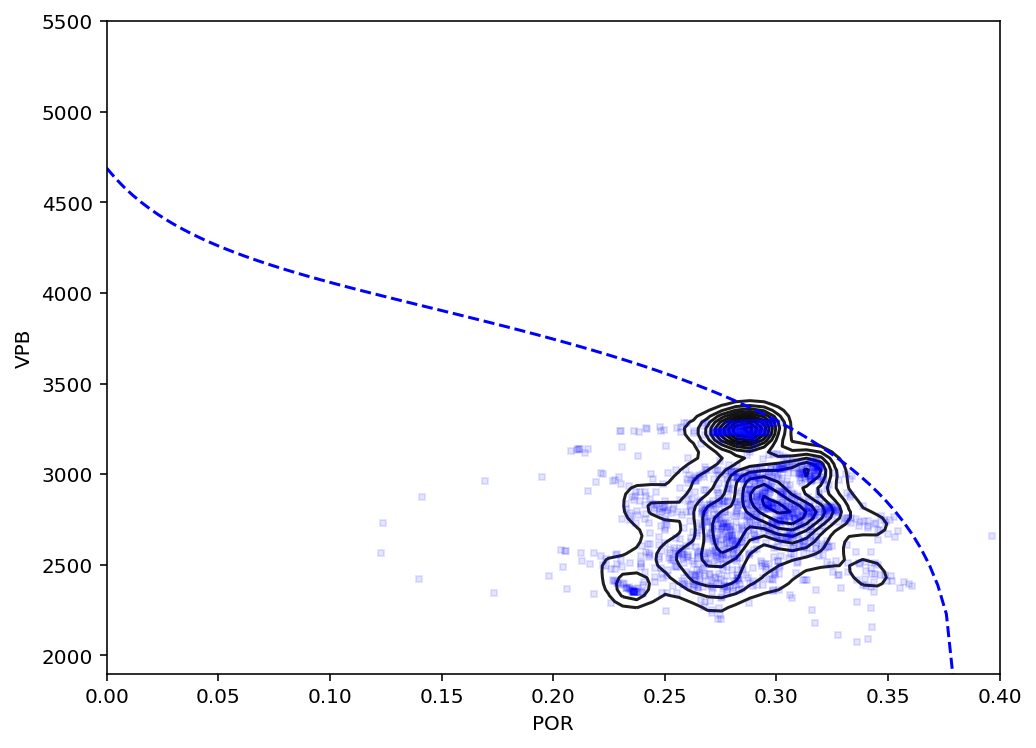

In [134]:
f,ax=plt.subplots(figsize=(8,6))
sns.kdeplot(resdata.POR,resdata.VPB, ax=ax,  levels=10, gridsize=50, color='k')
ax.plot(resdata.POR,resdata.VPB, 'sb', ms=3, alpha=0.1)
ax.plot(por_ccm,vp,'--b')
#ax.set_xlim(0.15,0.40)
#ax.set_ylim(2000,4000)
ax.set_xlim(0.,0.40)
ax.set_ylim(1900,5500)

### Log blocking and generation of pseudo-wells

We perform log blocking, i.e. take the most significant intervals to be studied in the wells and substitute in these intervals the average of the logs. This simplifies the problem and allows for a rapid iteration over possible lithology and fluid-replacement scenarios.

Four depths are selected to identify 3 intervals over which blocking is performed: top block (caprock), central block (reservoir) and lowermost block. The function `generate_wells` does the actual blocking plus modify fluid saturation, porosity and thickness in the central block and consequently (based on a rock physics model defined elsewhere) also the elastic logs Vp, Vs, density.

`generate_wells` requires in input a Pandas dataframe containing fluid substituted logs called `VP_FRMB`, `VS_FRMB`, `RHO_FRMB`, `VP_FRMO`, `VS_FRMO`, `RHO_FRMO`. Also required is a basename used to build the output csv datafiles in this way:

    [basename]_Z[thickness]_Sw[saturation]_Por[porosity].dat

The range of variations computed are:

* thickness: between 0 and 60 meters, step 20
* water saturation: between 0 and 1, step 0.25
* porosity: -10%, -5%, 0% and +5% of input porosity

Water saturation affects the elastic parameters (velocities and density) assuming a linear change from brine to oil filled rock. Porosity also assumes a linear relation with velocity according to a rock physics analysis done on well log data.

In [8]:
top_blocks = [2050,2154,2200,2245]
al.generate_wells(well,top_blocks,'TEST','SYNTWELLS')

To check the results, we load in a few blocky models and compare to the input well data using the function `blok_plot`:

In [9]:
blkmod1=pd.read_csv('SYNTWELLS/TEST_Z40_Sw100_Por20', index_col=0)
blkmod2=pd.read_csv('SYNTWELLS/TEST_Z40_Sw100_Por35', index_col=0)
blkmod3=pd.read_csv('SYNTWELLS/TEST_Z20_Sw100_Por35', index_col=0)

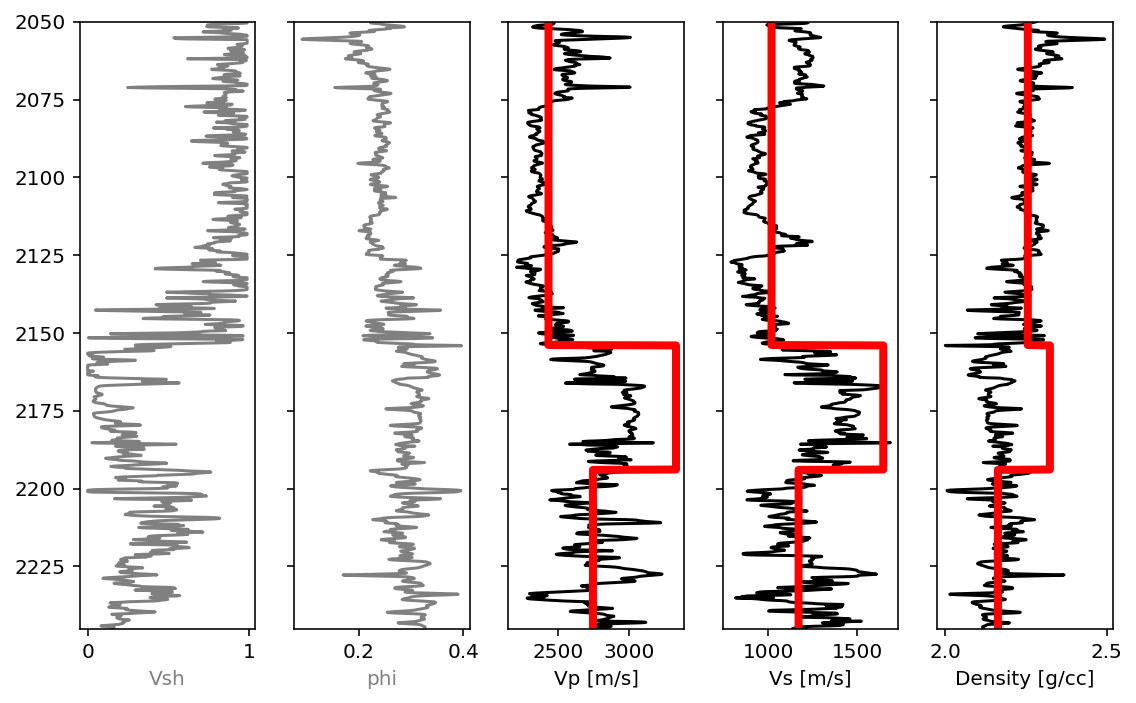

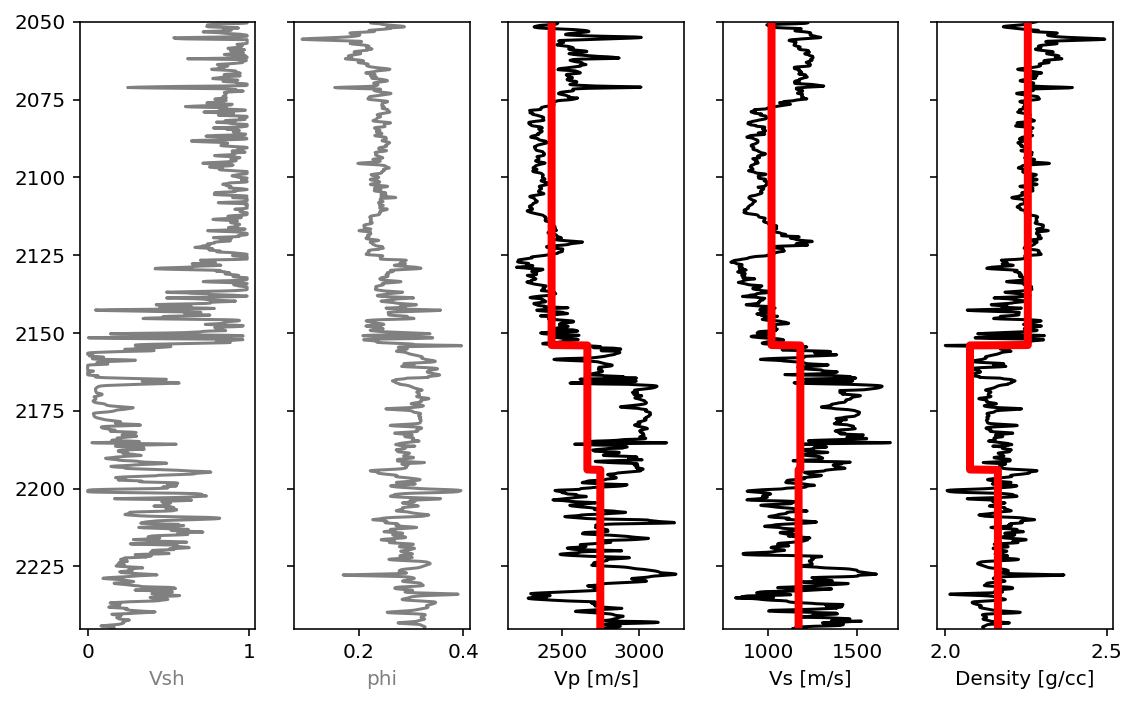

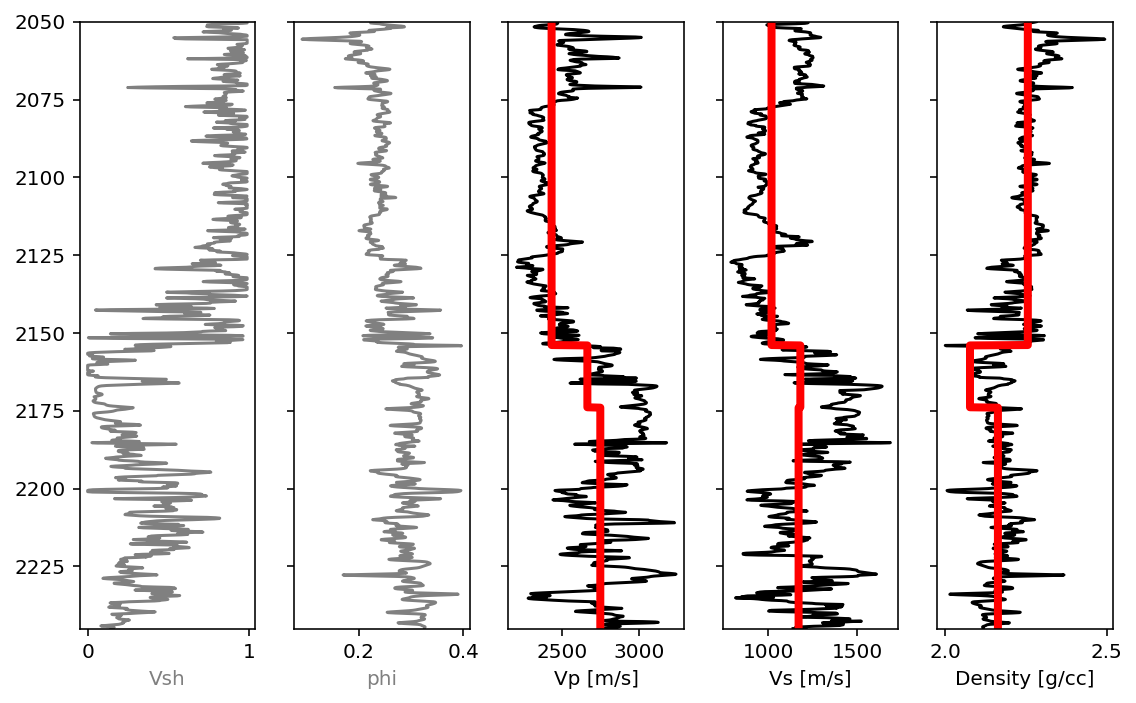

In [10]:
al.blok_plot(well,blkmod1)
al.blok_plot(well,blkmod2)
al.blok_plot(well,blkmod3)

define forward modeling parameters:

* sample rate: 4 ms
* wavelet: Ricker 30 Hz
* angle range: 5 and 30 degrees to simulate Near and Far traces

In [11]:
dt=.004
wavl=b.filters.ricker(.25, dt, 30)
ang=np.linspace(5,30,2)

Calculate simple time-depth tables from sonic measurements with function `td`, then we store into `topres_<well>` the top Heimdal converted to two-way-times.

In [12]:
tdr_w2=al.td(w2,KB=26,WD=109)
topres_w2=al.get_twt(tdr_w2,tops['15/5-5']['Heimdal'])

tdr_w3=al.td(w3,KB=26,WD=109)
topres_w3=al.get_twt(tdr_w2,tops['15/5-3']['Heimdal'])

tdr_w5=al.td(w5,KB=26,WD=109)
topres_w5=al.get_twt(tdr_w5,tops['15/5-6']['Heimdal'])

[TD] water bottom two-way-time: 0.147 [s]
[TD] sonic log start: 2013.253 [m] = 2.495 [s]
[TD] computed twt scale range: 2.495-2.926 [s]
[TD] water bottom two-way-time: 0.147 [s]
[TD] sonic log start: 200.150 [m] = 0.229 [s]
[TD] computed twt scale range: 0.229-3.625 [s]
[TD] water bottom two-way-time: 0.147 [s]
[TD] sonic log start: 2100.072 [m] = 2.604 [s]
[TD] computed twt scale range: 2.604-2.754 [s]


The function `get_well_files` is a simple function to read all the blocky pseudowells previously created with `generate_wells` and store them into an array (`well_files`):

In [14]:
tdr, topres=tdr_w2, topres_w2

well_files = al.get_well_files(wells_dir='SYNTWELLS', name='TEST')
t1=topres-0.048
t2=topres+0.208

The following cell block shows how to loop over the array `well_files` to convert the pseudowells in two-way-time, create synthetic seismograms and output all the synthetics to a  single Pandas dataframe.

Note that the function `make_synt` will compute as many traces as they are defined in the array `ang` so ideally we could compute full-offset seismograms; for simplicity however, we just create two traces (near and far).

In [15]:
megasynt = pd.DataFrame()
for ff in well_files:
    nn=pd.read_csv(ff, index_col=0)
    nnt,_,_ = al.welltime(nn,tdr,dt=dt,qcplot=False)
    rc,synt=al.make_synt(nnt,ang,wavl,method='aki')
    outdf = nnt[(nnt.index>=t1) & (nnt.index<=t2)].copy()
    it1=np.abs(nnt.index-t1).argmin()
    it2=np.abs(nnt.index-t2).argmin()
    synt_cut = synt[it1:it2,:]
    outdf['NEAR'] = synt_cut[:,0]
    outdf['FAR'] = synt_cut[:,1]
    outdf['WELL'] = ff[10:-16] # will pick up the well name
    outdf['ID'] = ff[-15:] 
    megasynt = megasynt.append(outdf)

We now modify the DataFrame `megasynt` to set the dtype of the two columns `WELL` and `ID` to _categorical_, which is not relevant for the current work, but may be in the future if we want to do some data-wrangling and plots in Pandas.

In [17]:
megasynt['WELL']=megasynt['WELL'].astype('category')
megasynt['ID']=megasynt['ID'].astype('category')

Output to `csv`:

In [18]:
megasynt.to_csv('syntdataset_TEST.csv')

Plots only a handful of pseudowell synthetics for QC (constant thickness 60m, constant porosity 35%, variable water saturation):

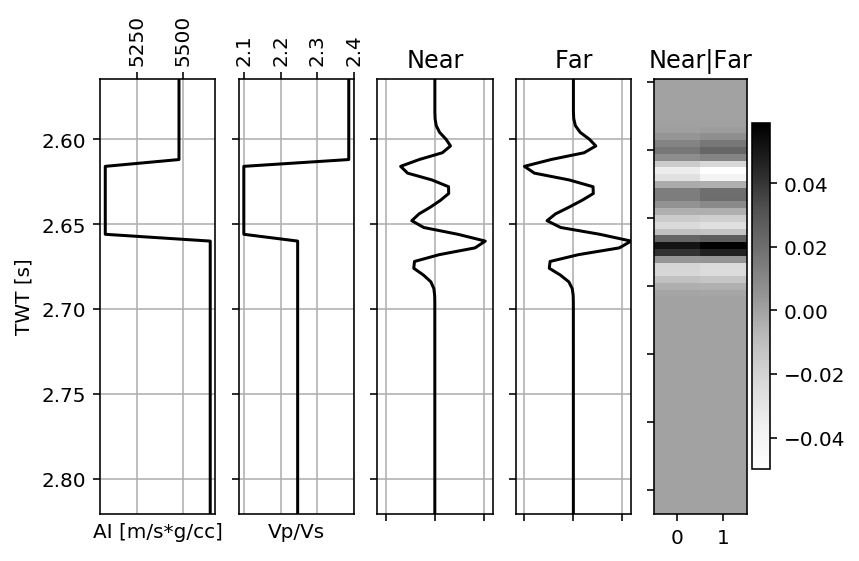

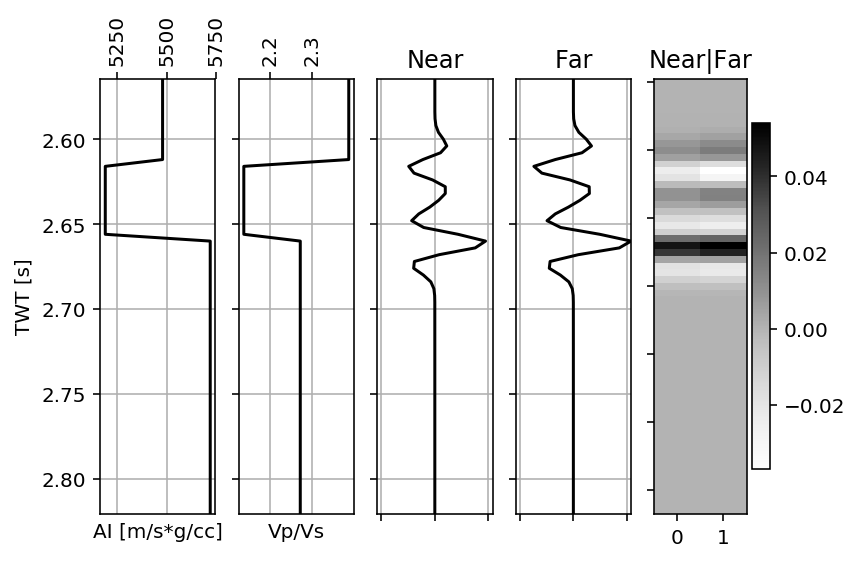

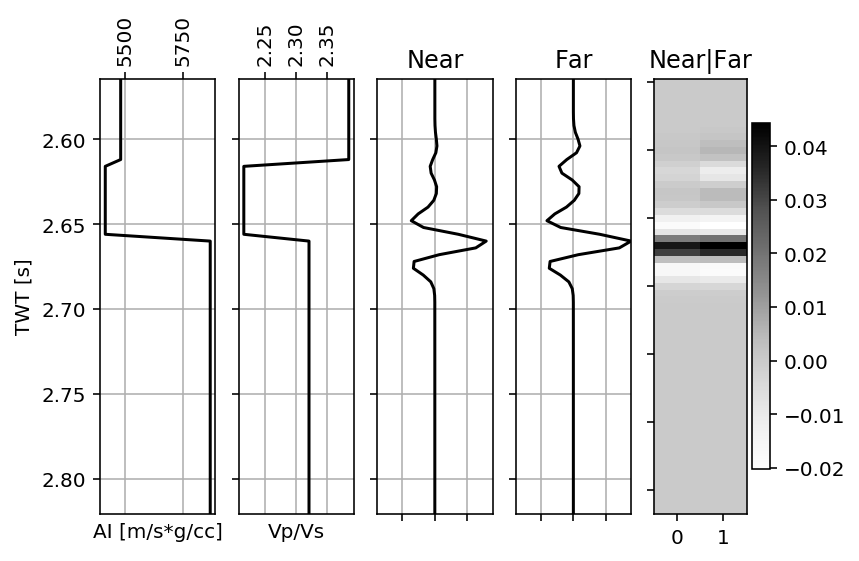

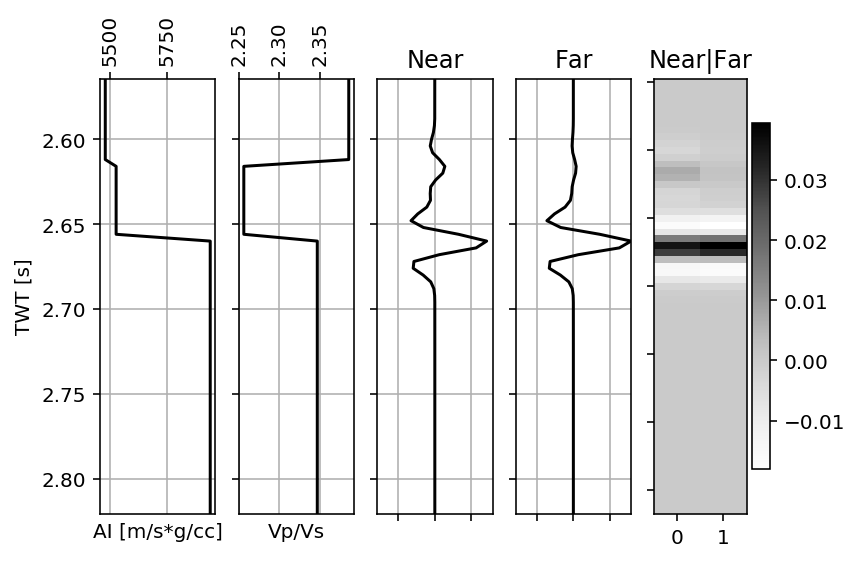

In [19]:
syntwells_dir='SYNTWELLS/'
test_files=[
'TEST_Z60_Sw000_Por35',
'TEST_Z60_Sw025_Por35',
'TEST_Z60_Sw075_Por35',
'TEST_Z60_Sw100_Por35']

for ff in test_files:
    nn=pd.read_csv(syntwells_dir+ff, index_col=0)
    nnt,_,_ = al.welltime(nn,tdr_w2,dt=dt,tops=tops_w2,qcplot=False)
    rc,synt=al.make_synt(nnt,ang,wavl,method='aki')
    al.plot_synt(nnt,synt,t1,t2,20)
#     plt.savefig('FIGS/{}_synth_variable_Sw.png'.format(names[i].replace('/','_')))

Reads back in the entire Pandas dataframe with the pseudowells near and far traces and plots them stacked side by side like if it was a seismic section:

Text(0.5, 1.0, '15/5-5 Far')

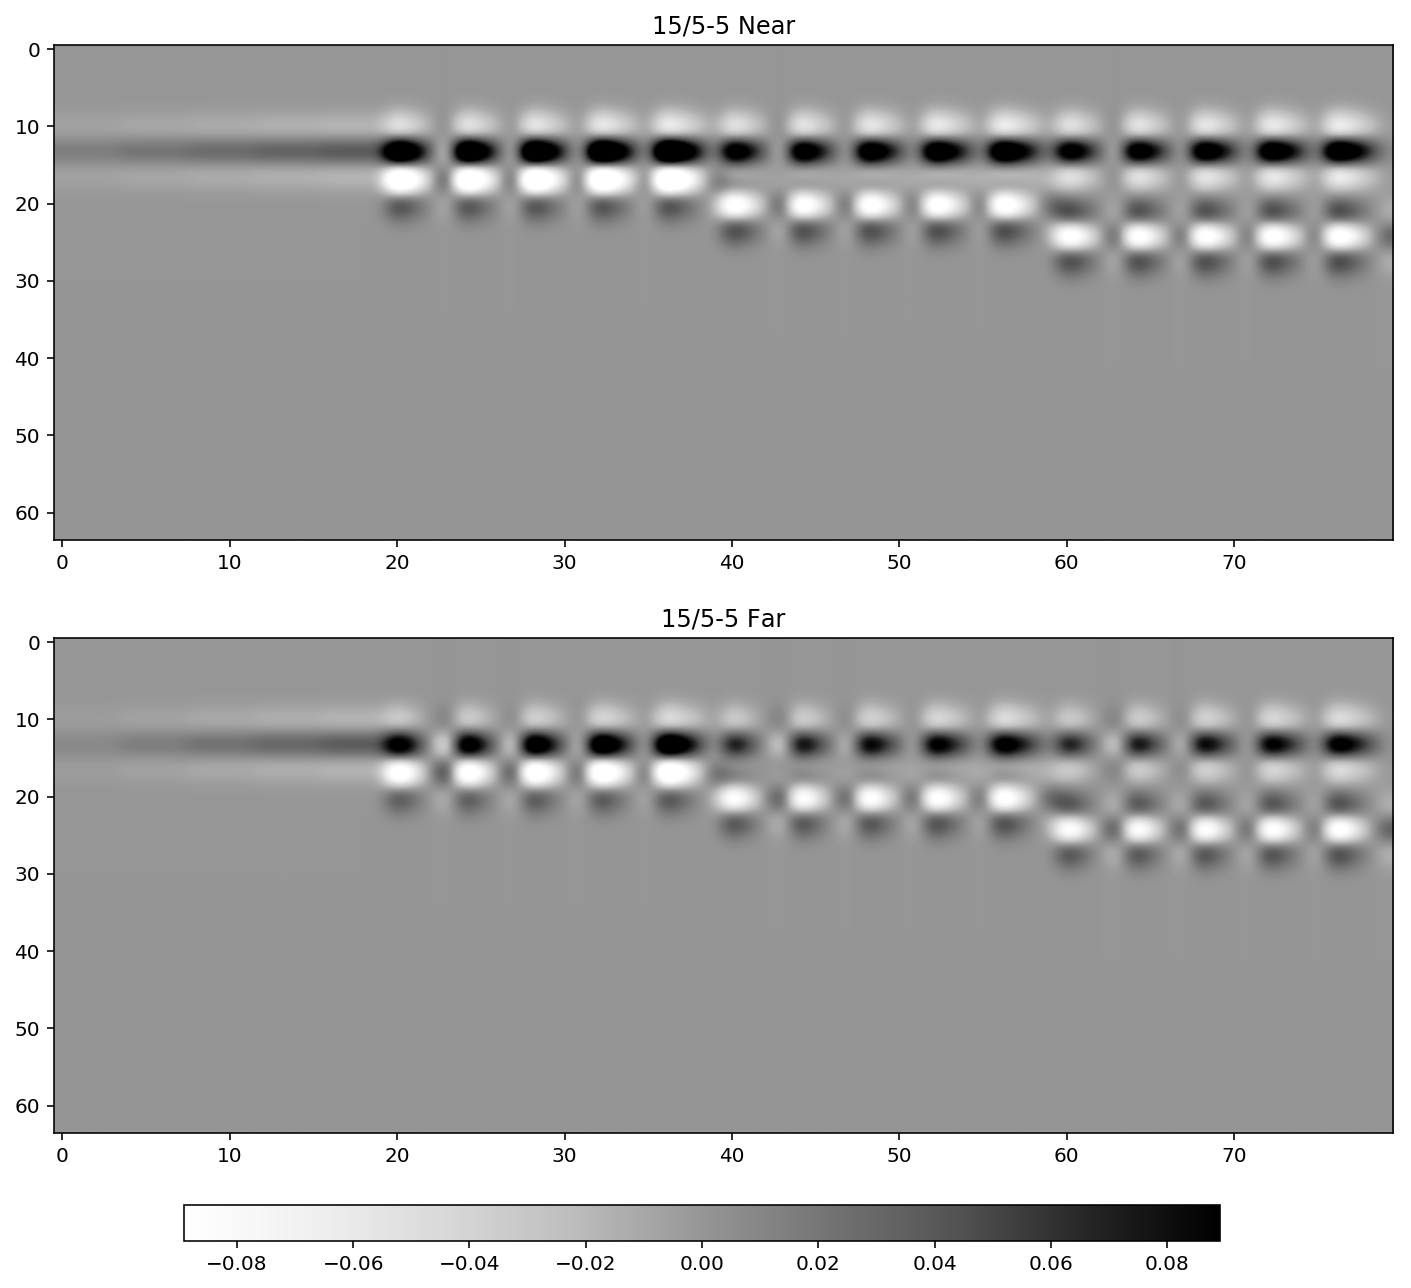

In [20]:
synt=pd.read_csv('syntdataset_TEST.csv')
nears, fars = al.get_nears_fars(synt)

clip=abs(np.percentile([nears,fars], 0.80))

f,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,10))
im0=ax[0].imshow(nears,cmap='Greys',vmax=clip,vmin=-clip,aspect='auto', interpolation='bicubic')
im1=ax[1].imshow(fars,cmap='Greys',vmax=clip,vmin=-clip,aspect='auto', interpolation='bicubic')
cax = f.add_axes([0.2, 0.05, 0.6, 0.025])
f.colorbar(im0, cax=cax, orientation='horizontal')
ax[0].set_title('15/5-5 Near')
ax[1].set_title('15/5-5 Far')
# plt.savefig('FIGS/{}_synth_variable_Sw.png'.format(uuu))

Reads traces reconstructed by Lukas' ML algorithm and display them side by side with input traces to show the "denoising" effect:

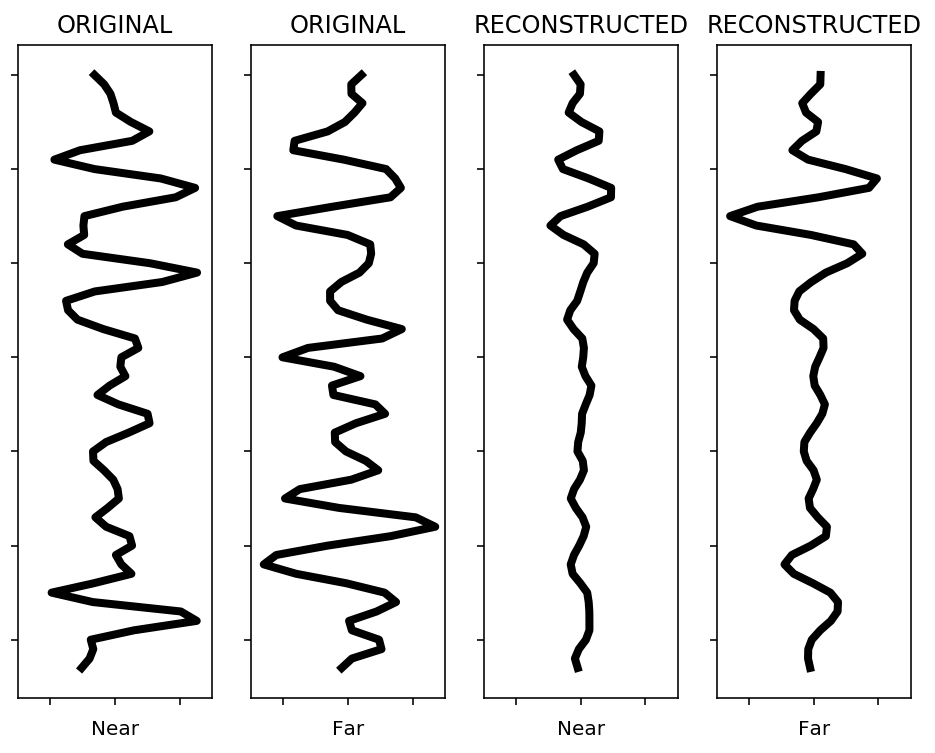

In [21]:
test_samples = np.load("test_out_49.npy")

opt={'linewidth':4, 'color':'black'}

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 6))
# real
ax[0].plot(test_samples[0,5,0,:], range(64), **opt) # near
ax[1].plot(test_samples[0,5,1,:], range(64), **opt) # far
# reconstructed
ax[2].plot(test_samples[1,5,0,:], range(64), **opt) # near
ax[3].plot(test_samples[1,5,1,:], range(64), **opt) # far
for aa in [ax[0],ax[2]]:
    aa.set_xlabel('Near')
for aa in [ax[1],ax[3]]:
    aa.set_xlabel('Far')
for aa in ax[:3]:
    aa.set_title('ORIGINAL')
for aa in ax[2:]:
    aa.set_title('RECONSTRUCTED')
for aa in ax:
    aa.set_yticklabels([])
    aa.set_xticklabels([])
    aa.invert_yaxis()
    aa.set_xlim(-3,3)
# plt.savefig('FIGS/original-reconstructed.png')

### references
    
* Avseth, P., Mukerji, T. & Mavko, G. Quantitative Seismic Interpretation. (Cambridge University Press, 2005).
    